# Chronological Drift in the Ember Dataset

This example demonstrates the drift tracking features of Goko. 

We start by importing the correct things, and sorting the ember dataset (training + test) by appearence date. We build the covertree on everything before July 2018, and then feed the data in chrological order to the covertree and track the KL divergence.

The major flaw with this experiment is the lack of an actual test set. The test set only consists of a couple of months, and does not overlap with the training so is not suited for this analysis. We have done this same experiment with a proper test/train split and it produces identical results.

We start by importing the data and sorting it into it's parts.

In [1]:
import os
import pandas as pd
import ember
import numpy as np
import matplotlib.pyplot as plt
from pygoko import CoverTree

datadir = "/localdata/ember2018/"

X, _  = ember.read_vectorized_features(datadir,"train")
metadata = pd.read_csv(os.path.join(datadir, "train_metadata.csv"), index_col=0)

split_date = "2018-07"
all_dates = list(set(metadata['appeared']))
all_dates.sort()
training_dates = [d for d in all_dates if d < split_date]

X_by_month = {k:X[metadata['appeared'] == k] for k in all_dates}

training_data = np.concatenate([X_by_month[k] for k in training_dates])
training_data = np.ascontiguousarray(training_data)

all_data = np.concatenate([X_by_month[k] for k in all_dates])
all_data = np.ascontiguousarray(all_data)

## Building the tree

We have 1m samples so we can pick a decent size for the leaf cutoff of 50. The features are nearly all integers, except for the byte histogram and entropy, so a minimum resolution index of 0 ignores the minor noise that these introduce.

In [2]:
tree = CoverTree()
tree.set_leaf_cutoff(50)
tree.set_scale_base(1.5)
tree.set_min_res_index(0)
tree.fit(training_data)

This is the actual object that computes the KL Divergence statistics between the samples we feed in and the new samples. 

Internally, it is an evidence hashmap containing categorical distributions, and a queue of paths. 
The sample's path is computed, we then push it onto the queue and update the evidence by incrementing the correct buckets 
in the evidence hashmap. If the queue is full, we pop off the oldest path and decrement the correct paths in the queue.

In [7]:
window_size = 100000
run_tracker = tree.kl_div_dirichlet(window_size)

total_kl_div = []
overall_stats = []
for i,datum in enumerate(all_data):
    run_tracker.push(datum)
    if i % 500 == 0:
        kl_div_stats = run_tracker.nodes_kl_div_stats()
        mll_stats = run_tracker.nodes_mll_stats()
        kl_div = run_tracker.overall_kl_div()
        mll = run_tracker.overall_mll()
        total_kl_div.append({
            "kl_div_stats" : kl_div_stats,
            "mll_stats" : mll_stats,
            "kl_div" : kl_div,
            "mll" : mll,
        })
    if i % 5000 == 0:
        overall_stats.append({"mll":run_tracker.nodes_mll(), "kl_div": run_tracker.nodes_kl_div()})

In [8]:
graph_mean = [s["corrected_mll_stats"]["moment1_nz"]/s["corrected_mll_stats"]["nz_count"] for s in total_kl_div]
graph_stats = [s["corrected_mll_stats"]["moment2_nz"]/s["corrected_mll_stats"]["nz_count"] - m*m for s,m in zip(total_kl_div, graph_mean)]

#graph_stats = [s["corrected_mll_stats"]["max"] for s in total_kl_div]
#graph_stats = graph_mean
graph_stats = [s["corrected_mll"] for s in total_kl_div]


We plot the results, with a tick mark to denote where the data switches from "known" time to "unknown" time

<module 'matplotlib.pyplot' from '/home/sven/.pyenv/versions/3.9.6/envs/goko/lib/python3.9/site-packages/matplotlib/pyplot.py'>

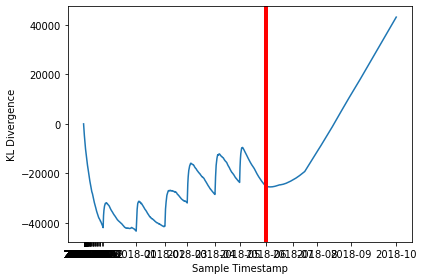

In [9]:
fig, ax = plt.subplots()
ax.plot(list(range(0,len(all_data),500)),graph_stats)
ax.set_ylabel('KL Divergence')
ax.set_xlabel('Sample Timestamp')
tick_len = 0
cutoff_len = 0
tick_locations = []
dates = [d for d in X_by_month.keys()]
for date in dates:
    if date == "2018-07":
        cutoff_len = tick_len
    tick_len += len(X_by_month[date])
    tick_locations.append(tick_len)
ax.set_xticks(tick_locations)
ax.set_xticklabels(dates)
ax.axvline(x=cutoff_len, linewidth=4, color='r')
fig.tight_layout()
fig.savefig("drift.png", bbox_inches='tight')
plt

KeyError: 'corrected_mll'

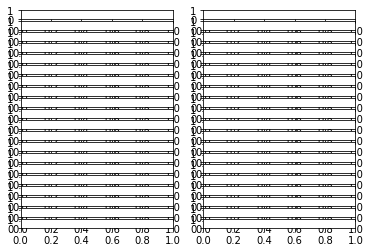

In [11]:
fig, ax = plt.subplots(20,2)
for i in range(20):
    data = [t[1] for t in overall_stats[i]["corrected_mll"]]
    ax[i][0].hist(data)
    ax[i][0].set_xlabel('corrected_mll')
    ax[i][0].set_ylabel(f'Bucket Count {18*i}')
    ax[i][0].set_yscale("log")
    data = [t[1] for t in overall_stats[i]["kl_div"]]
    ax[i][1].hist(data)
    ax[i][1].set_xlabel('kl_div')
    ax[i][1].set_ylabel(f'Bucket Count {18*i}')
    ax[i][1].set_yscale("log")
fig.tight_layout()
fig.set_figheight(40)
fig.set_figwidth(10)
fig.savefig("drift.png")
plt